In [1]:
%config IPCompleter.greedy = True

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
import numpy as np
import os
import datetime
import random as rn

import cv2

from matplotlib import pyplot as plt
%matplotlib inline

In [4]:
# np.random.seed(50)
# rn.seed(30)

import tensorflow as tf
tf.set_random_seed(30)

### 1. Load Dataset
***

In [5]:
train_path = 'data/train/'
val_path = 'data/val/'

train_doc = np.random.permutation(open('data/train.csv').readlines())
val_doc = np.random.permutation(open('data/val.csv').readlines())

In [6]:
num_train_sequences = len(train_doc)
num_val_sequences = len(val_doc)

print('total number of training sequences - {0}'.format(num_train_sequences))
print('total number of validation sequences - {0}'.format(num_val_sequences))

total number of training sequences - 663
total number of validation sequences - 100


### 2. Helper Functions
***

#### Display images in subplots

In [7]:
def plot_image(images, cmap=None):
    total_images = len(images)
    rows = 0

    if total_images < 6:
        rows = 1
    elif total_images % 5 == 0:
        rows = total_images / 5
    else:
        rows = (total_images // 5) + 1

    f, axes = plt.subplots(int(rows),
                           (5 if total_images > 5 else total_images),
                           sharex=True,
                           sharey=True)
    f.set_figwidth(15)
    f.set_figheight(5)
    row_elements = 5

    if rows == 1:
        for ax, image in zip(axes, images):
            ax.imshow(image, cmap)
    else:
        for i, row_ax in enumerate(axes):
            start_index = i * row_elements

            for ax, image in zip(row_ax, images[start_index:start_index + 5]):
                ax.imshow(image, cmap)

#### display images from randomly selected folders

shape of an image in the selected sequence : (120, 160, 3)


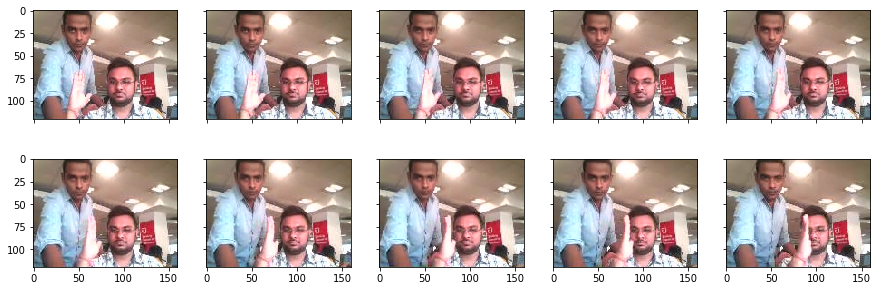

In [15]:
random_train_index = rn.randint(0, len(train_doc))

sequence_dir = train_doc[random_train_index].split(';')[0]

# list of all images in the folder
image_names = os.listdir(train_path + sequence_dir)

images = []
for name in image_names[0:30:3]:
    img = cv2.imread(train_path + sequence_dir + '/' + name)
    images.append(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

print('shape of an image in the selected sequence : {0}'.format(images[0].shape))    
    
plot_image(images)

### 2. Image Preprocessor
***

In [26]:
class ImagePreprocessor:
    def __init__(self,
                 height=120,
                 width=120,
                 channel=3,
                 affine=False,
                 crop=False,
                 edge=False,
                 normalize=False,
                 mnormalize=False,
                 resize=False,
                 smoothing=False):
        self.__height = height
        self.__width = width
        self.__channel = channel
        self._affine = affine
        self._crop = crop
        self._edge = edge
        self._normalize = normalize
        self._normalize_m = mnormalize
        self._resize = resize
        self._smoothing = smoothing

    def process_image(self, orig_image):
        pr_image = orig_image

        if self._crop:
            pr_image = self.__crop(pr_image)

        if self._resize:
            pr_image = self.__resize(pr_image)

        if self._normalize:
            pr_image = self.__normalize(pr_image)

        if self._normalize_m:
            pr_image = self.__normalize_mean(pr_image)
            
        if self._affine:
            pr_image = self.__affine(pr_image)
        
        if self._smoothing:
            pr_image = self.__smoothing(pr_image)

        if self._edge:
            pr_image = self.__edge_detection(pr_image)

        return pr_image

    def __crop(self, image):
        i_shape = image.shape
        return image[20:i_shape[0], 0:i_shape[1]]

    def __normalize(self, image):
        n_image = np.zeros((self.__height, self.__width, self.__channel))
        n_image = cv2.normalize(image, n_image, 0, 255, cv2.NORM_MINMAX)

        return n_image
    
    def __normalize_mean(self, image):
        n_image = np.zeros((self.__height, self.__width, self.__channel))
        n_image = cv2.normalize(image, n_image, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)
        
        return n_image

    def __resize(self, image):
        return cv2.resize(image, (self.__height, self.__width),
                          interpolation=cv2.INTER_AREA)

    def __smoothing(self, image):
        return cv2.GaussianBlur(image, (5, 5), cv2.BORDER_DEFAULT)

    def __edge_detection(self, image):
        return cv2.Canny(image, 100, 150)
    
    def __affine(self, image):
        dx, dy = np.random.randint(-1.7, 1.8, 2)
        M = np.float32([[1, 0, dx], [0, 1, dy]])

        return cv2.warpAffine(image, M, (image.shape[0], image.shape[1]))

preprocess images displayed earlier

shape of an image in the selected sequence : (120, 120, 3)


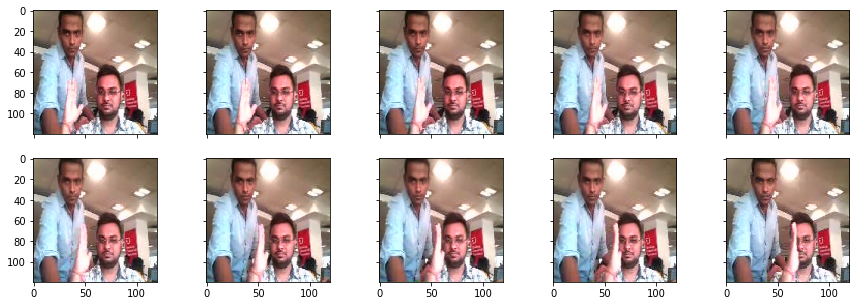

In [28]:
imagePreprocess = ImagePreprocessor(crop=False, mnormalize=True, resize=True, smoothing=False, affine = False)

pr_images = []

for name in image_names[0:30:3]:
    img = cv2.imread(train_path + sequence_dir + '/' + name)
    pr_image = imagePreprocess.process_image(orig_image=img)
    pr_images.append(cv2.cvtColor(pr_image, cv2.COLOR_BGR2RGB))

print('shape of an image in the selected sequence : {0}'.format(pr_images[0].shape))    
    
plot_image(pr_images)

preprocess images with edge detection = True and smoothing = False

** Canny algorithm performs a Gaussian smoothing before applying edge detection algorithm. Hence no need for an additional smoothing.

shape of an image in the selected sequence : (120, 120, 3)


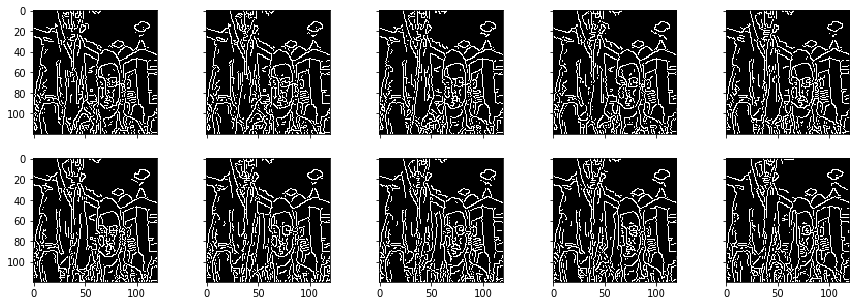

In [33]:
imagePreprocess = ImagePreprocessor(crop=True, normalize=True, resize=True, smoothing=False, edge=True)

pr_images = []

for name in image_names[0:30:3]:
    img = cv2.imread(train_path + sequence_dir + '/' + name)
    pr_image = imagePreprocess.process_image(orig_image=img)
    pr_images.append(cv2.cvtColor(pr_image, cv2.COLOR_BGR2RGB))

print('shape of an image in the selected sequence : {0}'.format(pr_images[0].shape))    
    
plot_image(pr_images)

### 3. Parameter Initialization
***

In [12]:
class ModelParameters:
    def __init__(self,
                 im_height=120,
                 im_width=120,
                 filters=[8, 16, 32, 64],
                 dense=[5000, 500, 5],
                 epochs=20,
                 batch_size=10,
                 lrate=0.001):
        self.__height = im_height
        self.__width = im_width
        self.__channels = 3

        self.FrameIndexes = 'ALL'
        self.Filters = filters
        self.DenseLayers = dense

        self.Epochs = epochs
        self.BatchSize = batch_size
        self.LRate = lrate

    @property
    def Filters(self):
        return self.__filters

    @Filters.setter
    def Filters(self, val):
        self.__filters = val

    @property
    def DenseLayers(self):
        return self.__dense

    @DenseLayers.setter
    def DenseLayers(self, val):
        self.__dense = val

    @property
    def FrameIndexes(self):
        return self.__frames

    @FrameIndexes.setter
    def FrameIndexes(self, val):
        if val == 'ALL':
            self.__frames = [x for x in range(0, 30)]
        else:
            self.__frames = [x for x in range(0, 30, 3)]
            self.__frames.append(30)

    @property
    def Epochs(self):
        return self.__epochs

    @Epochs.setter
    def Epochs(self, val):
        self.__epochs = val

    @property
    def BatchSize(self):
        return self.__bsize

    @BatchSize.setter
    def BatchSize(self, val):
        self.__bsize = val

    @property
    def LRate(self):
        return self.__lrate

    @LRate.setter
    def LRate(self, val):
        self.__lrate = val

    def set_image_dimensions(self, height, width):
        self.__height = height
        self.__width = width

    def input_shape(self):
        return (len(self.FrameIndexes), self.__height, self.__width, self.__channels)

    def optimizer(self, optimizers, otype='SGD'):
        if otype == 'ADAM':
            return optimizers.Adam(self.LRate)
        elif otype == 'ADELTA':
            return optimizers.Adadelta()
        else:
            return optimizers.SGD(lr=self.LRate, momentum=0.9, nesterov=True)

    def steps_per_epoch(self, num_train_sequences):
        if (num_train_sequences % self.BatchSize) == 0:
            return int(num_train_sequences / self.BatchSize)
        else:
            return (num_train_sequences // self.BatchSize) + 1

    def validation_steps(self, num_val_sequences):
        if (num_val_sequences % self.BatchSize) == 0:
            return int(num_val_sequences / self.BatchSize)
        else:
            return (num_val_sequences // self.BatchSize) + 1

### 4. Data Generator
***

In [13]:
def generator(source_path, folder_list, ipreprocessor, mparameters):

    img_idx = mparameters.FrameIndexes
    input_shape = mparameters.input_shape()
    batch_size = mparameters.BatchSize
    
    while True:
        # shuffle the array of video sequences prior to creating individual batches
        t = np.random.permutation(folder_list)

        num_batches = len(t) // batch_size

        for batch in range(num_batches):

            # x is the number of images you use for each video,
            # (y,z) is the final size of the input images
            # 3 is the number of channels RGB
            batch_data = np.zeros((batch_size, len(img_idx), input_shape[1],
                                   input_shape[2], input_shape[3]))
            
            # batch_labels is the one hot representation of the output
            batch_labels = np.zeros((batch_size, 5))

            for folder in range(batch_size):

                fl_index = folder + (batch * batch_size)
                fl_name = t[fl_index].strip().split(';')[0]

                # read all the images in the folder
                imgs = os.listdir(source_path + '/' + fl_name)

                # iterate iver the frames/images of a folder to read them in
                for idx, item in enumerate(img_idx):

                    image = cv2.imread(source_path + '/' + fl_name + '/' + imgs[item])

                    pr_image = ipreprocessor.process_image(orig_image=image)
                    
                    batch_data[folder, idx, :, :, 0] = pr_image[:, :, 0]
                    batch_data[folder, idx, :, :, 1] = pr_image[:, :, 1]
                    batch_data[folder, idx, :, :, 2] = pr_image[:, :, 2]

                batch_labels[folder, int(t[fl_index].strip().split(';')[2])] = 1

            yield batch_data, batch_labels

        # write the code for the remaining data points which are left after full batches
        if (len(folder_list) != batch_size * num_batches):

            batch_size = len(folder_list) - (batch_size * num_batches)
            batch_data = np.zeros((batch_size, len(img_idx), input_shape[1],
                                   input_shape[2], input_shape[3]))
            batch_labels = np.zeros((batch_size, 5))

            for folder in range(batch_size):

                fl_index = folder + (batch * batch_size)
                fl_name = t[fl_index].strip().split(';')[0]

                # read all the images in the folder
                imgs = os.listdir(source_path + '/' + fl_name)

                for idx, item in enumerate(img_idx):

                    image = cv2.imread(source_path + '/' + fl_name + '/' + imgs[item])

                    pr_image = ipreprocessor.process_image(orig_image=image)

                    batch_data[folder, idx, :, :, 0] = pr_image[:, :, 0]
                    batch_data[folder, idx, :, :, 1] = pr_image[:, :, 1]
                    batch_data[folder, idx, :, :, 2] = pr_image[:, :, 2]

                batch_labels[folder, int(t[fl_index].strip().split(';')[2])] = 1

            yield batch_data, batch_labels

### 5. Models
***

In [14]:
from keras.models import Sequential, Model
from keras.layers import Dense, GRU, Flatten, TimeDistributed, Flatten, BatchNormalization, Activation, Dropout
from keras.layers.convolutional import Conv3D, MaxPooling3D
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras import optimizers

Using TensorFlow backend.


In [15]:
curr_dt_time = datetime.datetime.now()
model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ', '').replace(':', '_') + '/'

if not os.path.exists(model_name):
    os.mkdir(model_name)

filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

In [16]:
checkpoint = ModelCheckpoint(filepath,
                             monitor='val_loss',
                             verbose=1,
                             save_best_only=False,
                             save_weights_only=False,
                             mode='auto',
                             period=1)

LR = ReduceLROnPlateau(monitor='val_loss',
                       factor=0.5,
                       patience=2,
                       cooldown=1,
                       verbose=1)

callbacks_list = [checkpoint, LR]

### Model #1A - Conv3D
*****

#### Network Topology

> -  *4 convolution units, 1 flatten layer, 2 dense layers, output softmax layer*
-  *convolution unit - Conv3D --> BatchNormalization --> Activation (Relu) --> MaxPooling3D*
-  *filters - 8, 16, 32, 64*
-  *dense layer sizes - 5000, 500*

#### Network Parameters

> -  *number of epochs = 20*
-  *batch size = 10*
-  *number of frames per sequence = 30*
-  *optimizer --> SGD + Momentum = 0.9 + Nesterov*
-  *learning rate --> 0.001*

#### Image Properties

> -  *height - 120 px*
-  *width - 120 px*
-  *channels - 3*
-  *cropped, normalized, resized, smoothened*

#### Best Model

> - *training accuracy --> **71.00** percent*
-  *test accuracy --> **71.14** percent*
-  *epoch --> 20*

In [17]:
def con3d_default_model(input_shape, nb_filters, nb_dense):

    model = Sequential()

    # layer 1
    model.add(
        Conv3D(nb_filters[0],
               kernel_size=(3, 3, 3),
               input_shape=input_shape,
               padding='same'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))

    model.add(MaxPooling3D(pool_size=(2, 2, 2)))

    # layer 2
    model.add(Conv3D(nb_filters[1], kernel_size=(3, 3, 3), padding='same'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))

    model.add(MaxPooling3D(pool_size=(2, 2, 2)))

    # layer 3
    model.add(Conv3D(nb_filters[2], kernel_size=(1, 3, 3), padding='same'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))

    model.add(MaxPooling3D(pool_size=(2, 2, 2)))

    # layer 4
    model.add(Conv3D(nb_filters[3], kernel_size=(1, 3, 3), padding='same'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))

    model.add(MaxPooling3D(pool_size=(2, 2, 2)))

    #Flatten Layers
    model.add(Flatten())

    # dense layer 1
    model.add(Dense(nb_dense[0], activation='relu'))
    model.add(Dropout(rate=0.5))

    # dense layer 2
    model.add(Dense(nb_dense[1], activation='relu'))
    model.add(Dropout(rate=0.5))

    #softmax layer
    model.add(Dense(nb_dense[2], activation='softmax'))

    return model

#### Model Parameters
***

In [18]:
imagePreprocessor = ImagePreprocessor(crop=True,
                                      normalize=True,
                                      resize=True,
                                      smoothing=True)

modelParameters = ModelParameters()

train_generator = generator(train_path, train_doc, imagePreprocessor, modelParameters)
val_generator = generator(val_path, val_doc, imagePreprocessor, modelParameters)

#### Model Summary
***

In [16]:
model_a = con3d_default_model(modelParameters.input_shape(),
                            modelParameters.Filters,
                            modelParameters.DenseLayers)

model_a.compile(optimizer=modelParameters.optimizer(optimizers),
              loss='categorical_crossentropy',
              metrics=['categorical_accuracy'])

print(model_a.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_1 (Conv3D)            (None, 30, 120, 120, 8)   656       
_________________________________________________________________
batch_normalization_1 (Batch (None, 30, 120, 120, 8)   32        
_________________________________________________________________
activation_1 (Activation)    (None, 30, 120, 120, 8)   0         
_________________________________________________________________
max_pooling3d_1 (MaxPooling3 (None, 15, 60, 60, 8)     0         
_________________________________________________________________
conv3d_2 (Conv3D)            (None, 15, 60, 60, 16)    3472      
_________________________________________________________________
batch_normalization_2 (Batch (None, 15, 60, 60, 16)    64        
_________________________________________________________________
activation_2 (Activation)    (None, 15, 60, 60, 16)    0         
__________

#### Train Model
***

In [17]:
model_a.fit_generator(train_generator,
                      steps_per_epoch=modelParameters.steps_per_epoch(num_train_sequences),
                      epochs=modelParameters.Epochs,
                      verbose=1,
                      callbacks=callbacks_list,
                      validation_data=val_generator,
                      validation_steps=modelParameters.validation_steps(num_val_sequences),
                      class_weight=None,
                      workers=1,
                      initial_epoch=0)

Epoch 1/20
67/67 [==============================] - 86s 1s/step - loss: 2.0855 - categorical_accuracy: 0.3259 - val_loss: 1.6228 - val_categorical_accuracy: 0.2600

Epoch 00001: val_loss improved from inf to 1.62277, saving model to model_init_2019-09-2302_48_56.992606/model-00001-2.09752-0.32579-1.62277-0.26000.h5
Epoch 2/20
67/67 [==============================] - 23s 342ms/step - loss: 2.1554 - categorical_accuracy: 0.3284 - val_loss: 2.9559 - val_categorical_accuracy: 0.2200

Epoch 00002: val_loss did not improve from 1.62277
Epoch 3/20
67/67 [==============================] - 24s 354ms/step - loss: 1.7550 - categorical_accuracy: 0.3781 - val_loss: 1.2805 - val_categorical_accuracy: 0.4900

Epoch 00003: val_loss improved from 1.62277 to 1.28051, saving model to model_init_2019-09-2302_48_56.992606/model-00003-1.75499-0.37811-1.28051-0.49000.h5
Epoch 4/20
67/67 [==============================] - 24s 363ms/step - loss: 1.6534 - categorical_accuracy: 0.3930 - val_loss: 1.5509 - val_ca

### Model #1B - Conv3D
***

#### Network Topology

> -  *same as Model 1A*
-  *reduce **Dropout Rate** from 0.50 to 0.25*

#### Network Parameters

> -  *same as Model 1A*

#### Image Properties

> -  *same as model 1A*

#### Best Model

> - *training accuracy --> **77.11** percent*
-  *validation accuracy --> **76.00** percent* 
-  *epoch --> 14*

In [21]:
def con3d_model_b(input_shape, nb_filters, nb_dense):
    model = Sequential()
    
    # layer 1
    model.add(Conv3D(nb_filters[0], 
                     kernel_size=(3,3,3), 
                     input_shape=input_shape,
                     padding='same'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))

    model.add(MaxPooling3D(pool_size=(2,2,2)))
    
    # layer 2
    model.add(Conv3D(nb_filters[1], 
                     kernel_size=(3,3,3), 
                     padding='same'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))

    model.add(MaxPooling3D(pool_size=(2,2,2)))
    
    # layer 3
    model.add(Conv3D(nb_filters[2], 
                     kernel_size=(1,3,3), 
                     padding='same'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))

    model.add(MaxPooling3D(pool_size=(2,2,2)))
    
    # layer 4
    model.add(Conv3D(nb_filters[3], 
                     kernel_size=(1,3,3), 
                     padding='same'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))

    model.add(MaxPooling3D(pool_size=(2,2,2)))

    #Flatten Layers
    model.add(Flatten())
    
    # dense layer 1
    model.add(Dense(nb_dense[0], activation='relu'))
    model.add(Dropout(0.25))
    
    # dense layer 2
    model.add(Dense(nb_dense[1], activation='relu'))
    model.add(Dropout(0.25))

    #softmax layer
    model.add(Dense(nb_dense[2], activation='softmax'))
    
    return model

#### Model Parameters
***

In [22]:
imagePreprocessor = ImagePreprocessor(crop=True,
                                      normalize=True,
                                      resize=True,
                                      smoothing=True)

modelParameters = ModelParameters()

train_generator = generator(train_path, train_doc, imagePreprocessor, modelParameters)
val_generator = generator(val_path, val_doc, imagePreprocessor, modelParameters)

#### Model Summary
***

In [19]:
model_b = con3d_model_b(modelParameters.input_shape(),
                            modelParameters.Filters,
                            modelParameters.DenseLayers)

model_b.compile(optimizer=modelParameters.optimizer(optimizers),
              loss='categorical_crossentropy',
              metrics=['categorical_accuracy'])

print(model_b.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_5 (Conv3D)            (None, 30, 120, 120, 8)   656       
_________________________________________________________________
batch_normalization_5 (Batch (None, 30, 120, 120, 8)   32        
_________________________________________________________________
activation_5 (Activation)    (None, 30, 120, 120, 8)   0         
_________________________________________________________________
max_pooling3d_5 (MaxPooling3 (None, 15, 60, 60, 8)     0         
_________________________________________________________________
conv3d_6 (Conv3D)            (None, 15, 60, 60, 16)    3472      
_________________________________________________________________
batch_normalization_6 (Batch (None, 15, 60, 60, 16)    64        
_________________________________________________________________
activation_6 (Activation)    (None, 15, 60, 60, 16)    0         
__________

#### Train Model
***

In [17]:
model_b.fit_generator(train_generator,
                      steps_per_epoch=modelParameters.steps_per_epoch(num_train_sequences),
                      epochs=modelParameters.Epochs,
                      verbose=1,
                      callbacks=callbacks_list,
                      validation_data=val_generator,
                      validation_steps=modelParameters.validation_steps(num_val_sequences),
                      class_weight=None,
                      workers=1,
                      initial_epoch=0)

Epoch 1/20
67/67 [==============================] - 121s 2s/step - loss: 1.5237 - categorical_accuracy: 0.4050 - val_loss: 1.6918 - val_categorical_accuracy: 0.4600

Epoch 00001: saving model to model_init_2019-09-2008_06_43.078706/model-00001-1.52881-0.40573-1.69177-0.46000.h5
Epoch 2/20
67/67 [==============================] - 27s 408ms/step - loss: 1.4347 - categorical_accuracy: 0.4776 - val_loss: 2.6945 - val_categorical_accuracy: 0.2900

Epoch 00002: saving model to model_init_2019-09-2008_06_43.078706/model-00002-1.43467-0.47761-2.69451-0.29000.h5
Epoch 3/20
67/67 [==============================] - 29s 428ms/step - loss: 1.3899 - categorical_accuracy: 0.4925 - val_loss: 1.1835 - val_categorical_accuracy: 0.5300

Epoch 00003: saving model to model_init_2019-09-2008_06_43.078706/model-00003-1.38989-0.49254-1.18346-0.53000.h5
Epoch 4/20
67/67 [==============================] - 28s 412ms/step - loss: 1.4538 - categorical_accuracy: 0.4129 - val_loss: 0.9504 - val_categorical_accuracy:

### Model #2A - Conv3D
*****

#### Network Topology

> -  *8 convolution layers, 5 MaxPooling layers, 1 flatten layer, 2 dense layers, output softmax layer*
-  *kernel size across convolution layers : (3, 3, 3)*
-  *number of feature maps : *16, 32, 64, 64, 128, 128, 128, 128*
-  *dense layer sizes - 4096, 4096*

#### Network Parameters

> -  *number of epochs = 30*
-  *batch size = 20*
-  *number of frames per sequence = 30*
-  *optimizer --> SGD + Momentum = 0.9 + Nesterov*
-  *learning rate --> 0.001*
-  *no dropout layer*

#### Image Properties

> -  *height - 120 px*
-  *width - 120 px*
-  *channels - 3*
-  *cropped, normalized, resized, no smoothing*

#### Best Model

> - *training accuracy --> **84.30** percent*
-  *test accuracy --> **78.00** percent*
-  *epoch --> 28*

In [ ]:
def con3d_model_2(input_shape, nb_filters, nb_dense):

    model = Sequential()

    # layer 1 - 16 kernels
    model.add(
        Conv3D(nb_filters[0],
               kernel_size=(3, 3, 3),
               input_shape=input_shape,
               padding='same'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    
    # pooling layer 1
    model.add(MaxPooling3D(pool_size=(1, 2, 2)))

    # layer 2 - 32 kernels
    model.add(Conv3D(nb_filters[1], kernel_size=(3, 3, 3), padding='same'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))

    # pooling layer 2
    model.add(MaxPooling3D(pool_size=(2, 2, 2)))

    # layer 3 - 64 kernels
    model.add(Conv3D(nb_filters[2], kernel_size=(3, 3, 3), padding='same'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))

    # layer 4 - 64 kernels
    model.add(Conv3D(nb_filters[2], kernel_size=(3, 3, 3), padding='same'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))

    # pooling layer 3
    model.add(MaxPooling3D(pool_size=(2, 2, 2)))

    # layer 5 - 128 kernels
    model.add(Conv3D(nb_filters[3], kernel_size=(3, 3, 3), padding='same'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))

    # layer 6 - 128 kernels
    model.add(Conv3D(nb_filters[3], kernel_size=(3, 3, 3), padding='same'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))

    # pooling layer 4
    model.add(MaxPooling3D(pool_size=(2, 2, 2)))

    # layer 7 - 128 kernels
    model.add(Conv3D(nb_filters[3], kernel_size=(3, 3, 3), padding='same'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))

    # layer 8 - 128 kernels
    model.add(Conv3D(nb_filters[3], kernel_size=(3, 3, 3), padding='same'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))

    # pooling layer 5
    model.add(MaxPooling3D(pool_size=(2, 2, 2)))
    
    #Flatten Layers
    model.add(Flatten())

    # dense layer 1 - 4096
    model.add(Dense(nb_dense[0], activation='relu'))

    # dense layer 2 - 4096
    model.add(Dense(nb_dense[1], activation='relu'))

    #softmax layer
    model.add(Dense(nb_dense[2], activation='softmax'))

    return model

#### Model Parameters
***

In [ ]:
imagePreprocessor = ImagePreprocessor(crop=True,
                                      normalize=True,
                                      resize=True,
                                      smoothing=False)

modelParameters = ModelParameters(filters=[16, 32, 64, 128], dense = [4096, 4096, 5],batch_size = 20)
modelParameters.Epochs = 30

train_generator = generator(train_path, train_doc, imagePreprocessor, modelParameters)
val_generator = generator(val_path, val_doc, imagePreprocessor, modelParameters)

#### Model Summary
***

In [22]:
model_c = con3d_model_2(modelParameters.input_shape(),
                            modelParameters.Filters,
                            modelParameters.DenseLayers)

model_c.compile(optimizer=modelParameters.optimizer(optimizers),
              loss='categorical_crossentropy',
              metrics=['categorical_accuracy'])

print(model_c.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_9 (Conv3D)            (None, 30, 120, 120, 16)  1312      
_________________________________________________________________
batch_normalization_9 (Batch (None, 30, 120, 120, 16)  64        
_________________________________________________________________
activation_9 (Activation)    (None, 30, 120, 120, 16)  0         
_________________________________________________________________
max_pooling3d_9 (MaxPooling3 (None, 30, 60, 60, 16)    0         
_________________________________________________________________
conv3d_10 (Conv3D)           (None, 30, 60, 60, 32)    13856     
_________________________________________________________________
batch_normalization_10 (Batc (None, 30, 60, 60, 32)    128       
_________________________________________________________________
activation_10 (Activation)   (None, 30, 60, 60, 32)    0         
__________

#### Train Model
***

In [17]:
model_c.fit_generator(train_generator,
                      steps_per_epoch=modelParameters.steps_per_epoch(num_train_sequences),
                      epochs=modelParameters.Epochs,
                      verbose=1,
                      callbacks=callbacks_list,
                      validation_data=val_generator,
                      validation_steps=modelParameters.validation_steps(num_val_sequences),
                      class_weight=None,
                      workers=1,
                      initial_epoch=0)

Epoch 1/30
34/34 [==============================] - 117s 3s/step - loss: 1.3338 - categorical_accuracy: 0.4533 - val_loss: 3.2999 - val_categorical_accuracy: 0.2300

Epoch 00001: val_loss improved from inf to 3.29994, saving model to model_init_2019-09-2108_51_01.327010/model-00001-1.34632-0.44796-3.29994-0.23000.h5
Epoch 2/30
34/34 [==============================] - 13s 393ms/step - loss: 1.6356 - categorical_accuracy: 0.4314 - val_loss: 2.4658 - val_categorical_accuracy: 0.3400

Epoch 00002: val_loss improved from 3.29994 to 2.46585, saving model to model_init_2019-09-2108_51_01.327010/model-00002-1.63562-0.43137-2.46585-0.34000.h5
Epoch 3/30
34/34 [==============================] - 16s 465ms/step - loss: 1.5419 - categorical_accuracy: 0.3922 - val_loss: 7.5071 - val_categorical_accuracy: 0.2300

Epoch 00003: val_loss did not improve from 2.46585
Epoch 4/30
34/34 [==============================] - 13s 395ms/step - loss: 1.3982 - categorical_accuracy: 0.4510 - val_loss: 1.3476 - val_c

Epoch 30/30
34/34 [==============================] - 15s 441ms/step - loss: 0.3554 - categorical_accuracy: 0.9020 - val_loss: 0.6276 - val_categorical_accuracy: 0.7900

Epoch 00030: val_loss did not improve from 0.62370


### Model #2B - Conv3D
*****

#### Network Topology

> -  *number of hidden layers : same as model 2A*
-  *kernel size across convolution layers : same as model 2A*
-  *number of **feature maps** : 32, 64, 128, 128, 256, 256, 256, 256*
-  *dense layer sizes : same as model 2A*

#### Network Parameters

> -  *same as model 2A*

#### Image Properties

> -  *same as model 2A*

#### Best Model

> - *training accuracy --> **82.00** percent*
-  *test accuracy --> **80.00** percent* 
-  *epoch --> 30*

#### Model Parameters
***

In [14]:
imagePreprocessor = ImagePreprocessor(crop=True,
                                      normalize=True,
                                      resize=True,
                                      smoothing=False)

modelParameters = ModelParameters(filters=[32, 64, 128, 256], dense = [4096, 4096, 5], batch_size = 20)
modelParameters.Epochs = 30

train_generator = generator(train_path, train_doc, imagePreprocessor, modelParameters)
val_generator = generator(val_path, val_doc, imagePreprocessor, modelParameters)

#### Model Summary
***

In [15]:
model_e = con3d_model_2(modelParameters.input_shape(),
                            modelParameters.Filters,
                            modelParameters.DenseLayers)

model_e.compile(optimizer=modelParameters.optimizer(optimizers),
              loss='categorical_crossentropy',
              metrics=['categorical_accuracy'])

print(model_e.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_1 (Conv3D)            (None, 30, 120, 120, 32)  2624      
_________________________________________________________________
batch_normalization_1 (Batch (None, 30, 120, 120, 32)  128       
_________________________________________________________________
activation_1 (Activation)    (None, 30, 120, 120, 32)  0         
_________________________________________________________________
max_pooling3d_1 (MaxPooling3 (None, 30, 60, 60, 32)    0         
_________________________________________________________________
conv3d_2 (Conv3D)            (None, 30, 60, 60, 64)    55360     
_________________________________________________________________
batch_normalization_2 (Batch (None, 30, 60, 60, 64)    256       
_________________________________________________________________
activation_2 (Activation)    (None, 30, 60, 60, 64)    0         
__________

#### Train Model
***

In [16]:
model_e.fit_generator(train_generator,
                      steps_per_epoch=modelParameters.steps_per_epoch(num_train_sequences),
                      epochs=modelParameters.Epochs,
                      verbose=1,
                      callbacks=callbacks_list,
                      validation_data=val_generator,
                      validation_steps=modelParameters.validation_steps(num_val_sequences),
                      class_weight=None,
                      workers=1,
                      initial_epoch=0)

Epoch 1/30
34/34 [==============================] - 108s 3s/step - loss: 1.3588 - categorical_accuracy: 0.4665 - val_loss: 2.2923 - val_categorical_accuracy: 0.3400

Epoch 00001: val_loss improved from inf to 2.29226, saving model to model_init_2019-09-2108_26_12.922339/model-00001-1.37161-0.46154-2.29226-0.34000.h5
Epoch 2/30
34/34 [==============================] - 11s 337ms/step - loss: 2.2141 - categorical_accuracy: 0.2745 - val_loss: 13.2056 - val_categorical_accuracy: 0.1800

Epoch 00002: val_loss did not improve from 2.29226
Epoch 3/30
34/34 [==============================] - 14s 404ms/step - loss: 1.6548 - categorical_accuracy: 0.3725 - val_loss: 10.0132 - val_categorical_accuracy: 0.2300

Epoch 00003: val_loss did not improve from 2.29226

Epoch 00003: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
Epoch 4/30
34/34 [==============================] - 15s 433ms/step - loss: 1.3645 - categorical_accuracy: 0.3824 - val_loss: 2.8793 - val_categorical_accuracy: 0

34/34 [==============================] - 15s 439ms/step - loss: 0.5064 - categorical_accuracy: 0.8235 - val_loss: 0.5523 - val_categorical_accuracy: 0.8000

Epoch 00030: val_loss did not improve from 0.55020
